## Intro to Portfolio Risk Management

**Single Asset**<br>
-Mean, Variance and Stand Dev, Skewness, Kurtosis.<br>
-Normality tests.<br>

**Portfolio - Multiple Assets**<br>
-Equal weighted (1/n) and market-cap weighted portfolios.<br>
-Correlation - covariance matrix.<br>
-Portfolio vol / stand dev.<br>
-Max Sharpe and Min Var portfolios (Markowitz).<br>

**Risk Factors**<br>
-Beta and the CAPM.<br>
-Fama French 3-factor model and EMH.<br>
-Other models.<br>

**Simple Risk Metrics**<br>
-Drawdown.<br>
-Historical value at risk.<br>
-Historical expected shortfall.<br>
-Parametric VaR and VaR scaling.<br>
-Simulated VaR: Random walk and Monte Carlo simulation.<br>

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import path

### Single asset

In [46]:
msft_prices = pd.read_csv('./assets/qrm_MSFTPrices.csv',index_col='Date')
msft_prices.head()

,Open,High,Low,Close,Volume,Adjusted
Date,,,,,,
2000-01-03,88.777,89.722,84.712,58.28125,53228400,38.527809
2000-01-04,85.893,88.588,84.901,56.31250,54119000,37.226345
2000-01-05,84.050,88.021,82.726,56.90625,64059600,37.618851
2000-01-06,84.853,86.130,81.970,55.00000,54976600,36.358688
2000-01-07,82.159,84.901,81.166,55.71875,62013600,36.833828


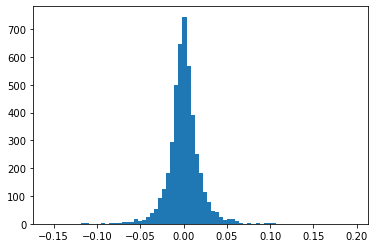

In [47]:
returns_plot = pd.DataFrame(msft_prices['Adjusted'].pct_change())
plt.hist(returns_plot, bins=75)
plt.show()

**First moment: mean**<br>
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mtext>Average Annualized Return</mtext>
  <mo>=</mo>
  <mo stretchy="false">(</mo>
  <mo stretchy="false">(</mo>
  <mn>1</mn>
  <mo>+</mo>
  <mi>&#x3BC;</mi>
  <msup>
    <mo stretchy="false">)</mo>
    <mrow>
      <mn>252</mn>
    </mrow>
  </msup>
  <mo stretchy="false">)</mo>
  <mo>&#x2212;</mo>
  <mn>1</mn>
</math>

In [48]:
mean_ann_ret = (((1+np.mean(returns_plot))**252)-1)*100
mean_ann_ret

Adjusted    9.985839
dtype: float64

**Second moment: vol**

In [49]:
volatility_ann = (np.std(returns_plot))*np.sqrt(252)*100
volatility_ann

Adjusted    30.703045
dtype: float64

**The variance is simply σ^2**

In [50]:
variance_ann = (volatility_ann/100)**2*100

display(np.var(returns_plot)*252*100)

variance_ann

Adjusted    9.42677
dtype: float64

Adjusted    9.42677
dtype: float64

**Third moment: skewness**<br>

A negative skew is a right-leaning curve, while positive skew is a left-leaning curve. In finance, you would tend to want positive skewness, as this would mean that the probability of large positive returns is unusually high, and the negative returns are more closely clustered and predictable.

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Negative_and_positive_skew_diagrams_%28English%29.svg/2880px-Negative_and_positive_skew_diagrams_%28English%29.svg.png>

In [51]:
# Import skew from scipy.stats
from scipy.stats import skew

# Calculate the third moment (skewness) of the returns distribution
returns_skewness = skew(returns_plot.dropna())
print(returns_skewness)

[0.21935459]


**Fourth moment: kurtosis**<br>

A measure of thickness of the tails of the distribution.<br>

Leptokurtic: when a distribution has positive excess kurtosis<br>

This (scipy.kurt) function actually returns the excess kurtosis, not the 4th moment itself. In order to calculate kurtosis, simply add 3 to the excess kurtosis returned by kurtosis().<br>

In [53]:
# Import kurtosis from scipy.stats
from scipy.stats import kurtosis

# Calculate the excess kurtosis of the returns distribution
excess_kurtosis = kurtosis(returns_plot.dropna())
print(excess_kurtosis)

# Derive the true fourth moment of the returns distribution
fourth_moment = excess_kurtosis+3
print(fourth_moment)

[10.31457262]
[13.31457262]


**Normality tests**

You can use the shapiro() function from scipy.stats to run a Shapiro-Wilk test of normality on the stock returns. The function will return two values in a list. The first value is the t-stat of the test, and the second value is the p-value. You can use the p-value to make a judgement about the normality of the data. If the p-value is less than or equal to 0.05, you can safely reject the null hypothesis of normality and assume that the data are non-normally distributed.

In [54]:
# Import shapiro from scipy.stats
from scipy.stats import shapiro

# Run the Shapiro-Wilk test on the stock returns
shapiro_results = shapiro(returns_plot.dropna())
print("Shapiro results:", shapiro_results)

# Extract the p-value from the shapiro_results
p_value = shapiro_results.pvalue
print("P-value: ", p_value)

Shapiro results: ShapiroResult(statistic=0.9003633260726929, pvalue=0.0)
P-value:  0.0


### Portfolio of assets

In [55]:
big9 = pd.read_csv('./assets/qrm_Big9Returns2017.csv',index_col='Date')
big9.head()

,AAPL,MSFT,XOM,JNJ,JPM,AMZN,GE,FB,T
Date,,,,,,,,,
2017-01-03,0.002849,0.007081,0.006980,0.005468,0.010894,0.005068,0.002848,0.015732,0.011521
2017-01-04,-0.001119,-0.004474,-0.011002,-0.001640,0.001844,0.004657,0.000316,0.015660,-0.005811
2017-01-05,0.005085,0.000000,-0.014907,0.010463,-0.009205,0.030732,-0.005678,0.016682,-0.002806
2017-01-06,0.011148,0.008668,-0.000565,-0.004792,0.000116,0.019912,0.002855,0.022707,-0.019924
2017-01-09,0.009159,-0.003183,-0.016497,-0.000172,0.000697,0.001168,-0.004745,0.012074,-0.012585


**Calculating portfolio returns**

In [66]:
# Finish defining the portfolio weights as a numpy array
portfolio_weights = np.array([0.12, 0.15, 0.08, 0.05, 0.09, 0.10, 0.11, 0.14, 0.16])

# Calculate the weighted stock returns
WeightedReturns = big9.mul(portfolio_weights, axis=1)

# Calculate the portfolio returns
returns_plot['Portfolio'] = WeightedReturns.sum(axis=1)

**Equally weighted portfolios**<br>
When comparing different portfolios, you often want to consider performance versus a naive equally-weighted portfolio. If the portfolio doesn't outperform a simple equally weighted portfolio, you might want to consider another strategy, or simply opt for the naive approach if all else fails. You can expect equally-weighted portfolios to tend to outperform the market when the largest companies are doing poorly. This is because even tiny companies would have the same weight in your equally-weighted portfolio as Apple or Amazon, for example.

In [67]:
numstocks = 9
eq_weights = [1/numstocks for i in range(numstocks)] # OR use np.repeat(1/numstocks,numstocks)

# Calculate the portfolio returns
returns_plot['EQ_Portfolio'] = big9.mul(eq_weights, axis=1).sum(axis=1)

**Market-cap weighted portfolios**<br>
Conversely, when large companies are doing well, market capitalization, or "market cap" weighted portfolios tend to outperform. This is because the largest weights are being assigned to the largest companies, or the companies with the largest market cap.

In [68]:
# Create an array of market capitalizations (in billions)
market_capitalizations = np.array([601.51, 469.25, 349.5, 310.48, 299.77, 356.94, 268.88, 331.57, 246.09])

# Calculate the market cap weights
mcap_weights = market_capitalizations/market_capitalizations.sum()

returns_plot['MC_Portfolio'] = big9.mul(mcap_weights, axis=1).sum(axis=1)

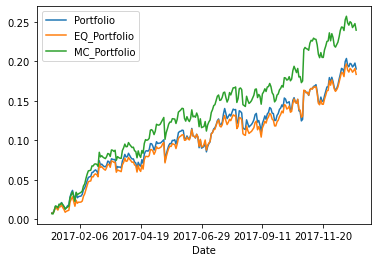

In [69]:
# Plot the cumulative portfolio returns over time
CumulativeReturns = ((1+returns_plot[['Portfolio','EQ_Portfolio','MC_Portfolio']]).cumprod()-1)
CumulativeReturns.plot()
plt.show()

## Quant Risk Management

**Modern portfolio theory**<br>
-Efficient frontier and mean/var optimisation.<br>

**Value at risk and Conditional VaR**<br>
-Calculate and interpret VaR and CVaR.<br>

**Portfolio hedging with options**<br>
-akjscb<br>

**Parametric estimation of VaE**<br>
-Goodness of fit vs normal and t-student dist through visualisation.<br>
-Anderson-Darling test.<br>
-Skewness test.<br>

**Historical and Monte Carlo simulation**<br>
-Historical simulation VaR.<br>
-Monte Carlo simulation Var.<br>

**Structural breaks**<br>
-Chow test: null of no structural break | period regression compared with before / after break.<br>

**Extreme value theory**<br>
-Model the tail losses (losses exceeding some value).<br>
-Block maxima.<br>
-Pot over threshold.<br>

**Kernel density function**<br>

**Neural networks risk management**<br>
-Real time risk management.<br>